#Cálculos básicos e do RSI usando pandas_ta

In [ ]:
!pip uninstall tensorflow --quiet

Proceed (Y/n)? Y


In [ ]:
!pip install tensorflow==2.12.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install pandas_ta --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --upgrade -q mplfinance --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install yfinance --quiet

In [ ]:
!pip install alpha_vantage --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import pandas_ta as ta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import mplfinance as mpf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from datetime import datetime, timedelta
from alpha_vantage.foreignexchange import ForeignExchange

In [ ]:
# Alpha Vintage APi KEY - 5EGOWEEB9H0ISU0I

In [ ]:
name_file = 'EURUSD_1D'

# Substitua 'YOUR_API_KEY' pelo seu próprio token de acesso da Alpha Vantage
api_key = '5EGOWEEB9H0ISU0I'

# Crie uma instância do ForeignExchange com a chave da API
forex = ForeignExchange(key=api_key)

# Obtenha os dados históricos diários
data, meta_data = forex.get_currency_exchange_daily(
    from_symbol='EUR', to_symbol='USD', outputsize='full'
)

In [ ]:
# Converter os dados em um DataFrame
df = pd.DataFrame(data).T  # O ".T" faz a transposição das linhas e colunas
# Renomear a coluna para "Close"
df = df.rename(columns={'4. close': 'close'})
df = df[::-1]
df.head()

,1. open,2. high,3. low,close
2004-08-20,1.23620,1.23820,1.22740,1.23040
2004-08-23,1.23150,1.23160,1.21290,1.21300
2004-08-24,1.21370,1.21660,1.20580,1.20790
2004-08-25,1.20800,1.21150,1.20490,1.20800
2004-08-26,1.20860,1.21210,1.20370,1.21010


In [ ]:
# Converter a coluna "close" para o tipo de dados float
df['close'] = df['close'].astype(float)
df.head()

,1. open,2. high,3. low,close
2004-08-20,1.23620,1.23820,1.22740,1.2304
2004-08-23,1.23150,1.23160,1.21290,1.2130
2004-08-24,1.21370,1.21660,1.20580,1.2079
2004-08-25,1.20800,1.21150,1.20490,1.2080
2004-08-26,1.20860,1.21210,1.20370,1.2101


In [ ]:
# Converter o índice (datas) para o formato de data
df['rsi'] = ta.rsi(df.close, 5)
df = df.dropna()
df.reset_index(inplace=True)

df.head()

,index,1. open,2. high,3. low,close,rsi
0,2004-08-27,1.21000,1.21350,1.19940,1.2012,8.556469
1,2004-08-30,1.20150,1.20690,1.19850,1.2043,23.164218
2,2004-08-31,1.20510,1.21940,1.20380,1.2174,58.327943
3,2004-09-01,1.21850,1.22170,1.21430,1.2193,61.520598
4,2004-09-02,1.21860,1.21990,1.21370,1.2170,55.129502


In [ ]:
# Exibir o DataFrame
c = df.loc[:,['rsi','close','index']]
c.tail()

,rsi,close,index
4990,50.984512,1.05585,2023-10-16
4991,55.089202,1.05742,2023-10-17
4992,43.859829,1.05358,2023-10-18
4993,56.746378,1.05807,2023-10-19
4994,59.707451,1.05922,2023-10-20


In [ ]:
df.shape

(4995, 6)

###Rede LSTM básica

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
n = 2000

In [ ]:
rsi = []
rsi = c.loc[len(df)-n:,['rsi','index']]

rsi.reset_index(inplace=True)
#

rsi['Time'] = pd.to_datetime(rsi['index'])
rsi = rsi.set_index('Time')
rsi = rsi.drop(['index','level_0'],axis=1)

rsi.tail()

,rsi
Time,
2023-10-16,50.984512
2023-10-17,55.089202
2023-10-18,43.859829
2023-10-19,56.746378
2023-10-20,59.707451


In [ ]:
# Preprocess the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(rsi['rsi'].values.reshape(-1, 1))

In [ ]:
# Define the training and testing data
train_size = int(len(df_scaled) * 0.9)
train_data = df_scaled[:train_size, :]
test_data = df_scaled[train_size:, :]

In [ ]:
# Define the function to create a sliding window dataset
def create_dataset(dataset, time_steps=1):
    X_data, y_data = [], []
    for i in range(len(dataset)-time_steps-1):
        X_data.append(dataset[i:(i+time_steps), 0])
        y_data.append(dataset[i + time_steps, 0])
    return np.array(X_data), np.array(y_data)

In [ ]:
# Define the time steps and create the sliding window dataset
time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [ ]:
# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
28/28 [==============================] - 24s 88ms/step - loss: 0.0754 - val_loss: 0.0412
Epoch 2/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0462 - val_loss: 0.0397
Epoch 3/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0436 - val_loss: 0.0390
Epoch 4/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0420 - val_loss: 0.0372
Epoch 5/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0410 - val_loss: 0.0351
Epoch 6/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0395 - val_loss: 0.0340
Epoch 7/50
28/28 [==============================] - 0s 14ms/step - loss: 0.0378 - val_loss: 0.0304
Epoch 8/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0352 - val_loss: 0.0272
Epoch 9/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0330 - val_loss: 0.0249
Epoch 10/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0301 - val_loss: 0.0231
Epoch 11

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

5/5 [==============================] - 1s 6ms/step


In [ ]:
# Inverse transform the predicted and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = y_test.reshape(y_pred.shape[0], 1)
y_test = scaler.inverse_transform(y_test)

In [ ]:
y_pred.shape

(139, 1)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: ', mse)
print('MSLE: ', msle)
print('MAE: ', mae)
print('R-squared: ', r2)

MSE:  128.16813566010603
MSLE:  0.08184602451958226
MAE:  9.886134445146189
R-squared:  0.6422517156904168


In [ ]:
from datetime import datetime
dias = np.array(rsi.index.values)
dias = np.array(rsi.index.values, dtype='datetime64[D]')
datas_formatadas = [str(data) for data in dias]
datas = [x for x in datas_formatadas]
datas = np.array(datas)

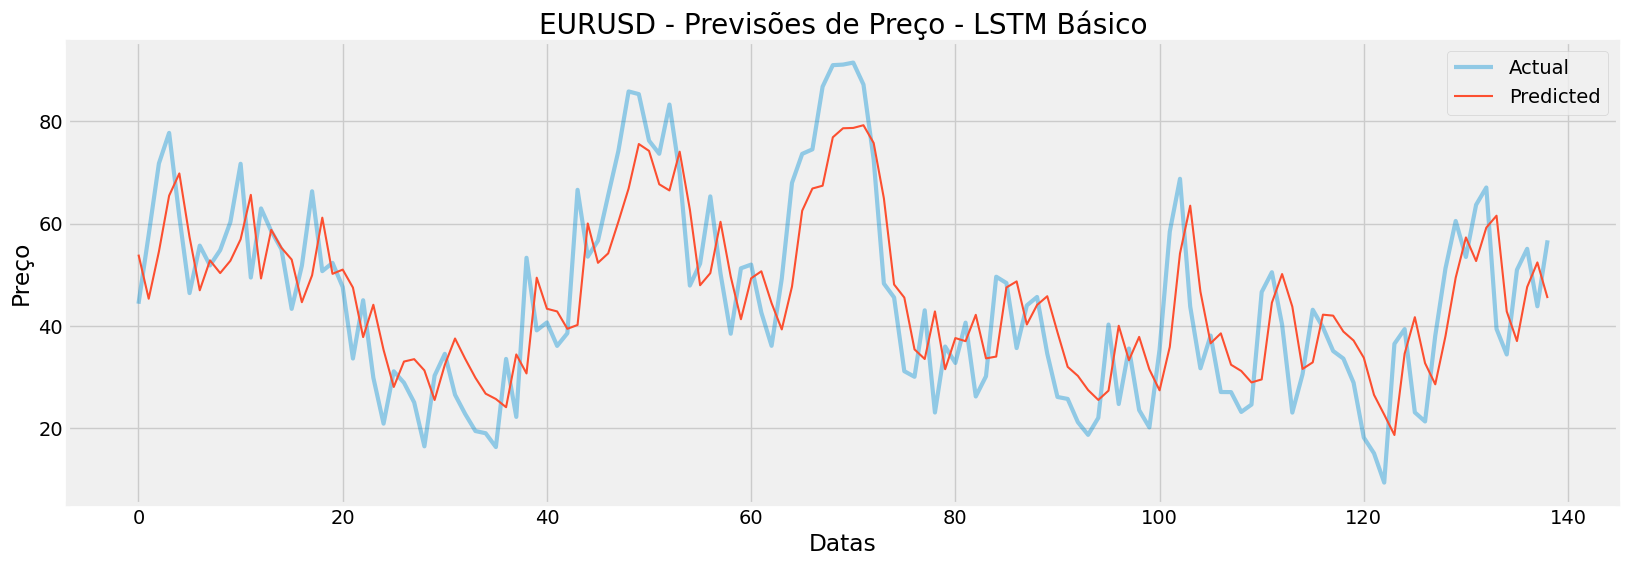

In [ ]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 6))
plt.style.use('fivethirtyeight')
plt.plot(y_test, label='Actual', linewidth = 3, alpha = 0.4)
plt.plot(y_pred, label='Predicted', linewidth = 1.5)
plt.xlabel('Datas')
plt.ylabel('Preço')
plt.title('EURUSD - Previsões de Preço - LSTM Básico')
plt.legend()
plt.savefig('EURUSD - Previsões de Preço - LSTM Básico.png', format='png')
plt.show()

###LSTM modelo melhorado

1- Aumentar o número de camadas LSTM: Uma maneira de melhorar o desempenho do modelo é adicionar mais camadas LSTM ao modelo. Isso pode ajudar o modelo a capturar padrões mais complexos nos dados.

2- Aumentar o número de neurônios em cada camada: Outra maneira de melhorar o desempenho do modelo é aumentar o número de neurônios em cada camada LSTM. Isso pode ajudar o modelo a aprender relações mais complexas entre as características de entrada e a variável alvo.

3- Ajustar a taxa de aprendizado: A taxa de aprendizado determina o quanto o modelo ajusta seus pesos em resposta ao erro entre os valores previstos e reais. Uma taxa de aprendizado pequena pode desacelerar o processo de treinamento, enquanto uma taxa de aprendizado grande pode fazer com que o modelo ultrapasse os pesos ótimos. Ajustar a taxa de aprendizado pode melhorar o desempenho do modelo.

4- Adicionar camadas de dropout: Camadas de dropout podem ser adicionadas ao modelo para evitar o overfitting. Essa técnica elimina aleatoriamente alguns neurônios durante o treinamento, o que pode ajudar o modelo a generalizar melhor para novos dados.

5- Experimentar diferentes funções de ativação: A escolha da função de ativação pode afetar a capacidade do modelo de aprender relações complexas nos dados. Experimentar diferentes funções de ativação, como tanh, relu e sigmoid, pode ajudar a melhorar o desempenho do modelo.

6- Utilizar mais dados: Aumentar a quantidade de dados usados para treinar o modelo pode melhorar seu desempenho. Isso pode ser alcançado aumentando o número de anos de dados históricos ou utilizando recursos adicionais, como dados de sentimento de notícias ou indicadores técnicos.

7- Utilizar uma função de perda diferente: A escolha da função de perda também pode afetar o desempenho do modelo. Utilizar uma função de perda mais apropriada para dados de séries temporais, como o erro médio quadrado logarítmico (MSLE), pode ajudar a melhorar a precisão do modelo

In [ ]:
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

###LSTM para prever precos - Hyperparametros

https://medium.com/datadriveninvestor/stock-price-prediction-with-chatgpt-and-finazon-f641d301cdac

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
# Define the function to create the LSTM model
def create_model(neurons=50, layers=2, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    for i in range(layers):
        model.add(LSTM(units=neurons, return_sequences=True, input_shape=(train_data.shape[1], 1)))
        model.add(Dropout(dropout))
    model.add(LSTM(units=neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'neurons': [64, 128, 256],
    'layers': [2, 3, 4],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.01]
}

In [ ]:
# Define the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Create the KerasRegressor for hyperparameter tuning
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# Perform the hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid.fit(train_data, train_data)

# Print the best parameters and score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", np.sqrt(-grid_result.best_score_))

Best parameters:  {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 128}
Best score:  0.0049309519462977965


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000024 using {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 128}
-0.000095 (0.000042) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 64}
-0.000024 (0.000023) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 128}
-0.000086 (0.000089) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 256}
-0.000247 (0.000120) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.01, 'neurons': 64}
-0.000636 (0.000302) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.01, 'neurons': 128}
-0.000730 (0.000643) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.01, 'neurons': 256}
-0.000134 (0.000084) with: {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 64}
-0.000094 (0.000017) with: {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 128}
-0.000155 (0.000192) with: {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 256}
-0.000569 (0.000489) with: {'dropout': 0.

In [ ]:
# Get best parameters to build de A.I. model
best_model = grid_result.best_estimator_.model

In [ ]:
# Use the best model to make predictions on the test data
predictions = best_model.predict(test_data.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 1s 4ms/step


In [ ]:
# Evaluate the model
#mse = mean_squared_error(y_test, y_pred)
# msle = mean_squared_log_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(rsi['rsi'][train_size:], predictions)
mae = mean_absolute_error(rsi['rsi'][train_size:], predictions)
r2 = r2_score(rsi['rsi'][train_size:], predictions)

print('MSE: ', mse)
print('MAE: ', mae)
#print('MSLE: ', msle)
print('R-squared: ', r2)

MSE:  0.06379102031906557
MAE:  0.24371701384124375
R-squared:  0.9998187704642609


In [ ]:
import joblib  # ou import pickle

scaler_filename = 'scaler_rsi_lstm_hiperparametros.pkl'  # Escolha um nome de arquivo
joblib.dump(scaler, scaler_filename)  # Ou use pickle.dump(scaler, open(scaler_filename, 'wb'))

# Especifique o nome completo do arquivo para o modelo
model_filename = 'bestModel_rsi_lstm_hiperparametros.h5'

# Salve o melhor modelo
best_model.save(model_filename)

In [ ]:
predictions.shape

(200, 1)

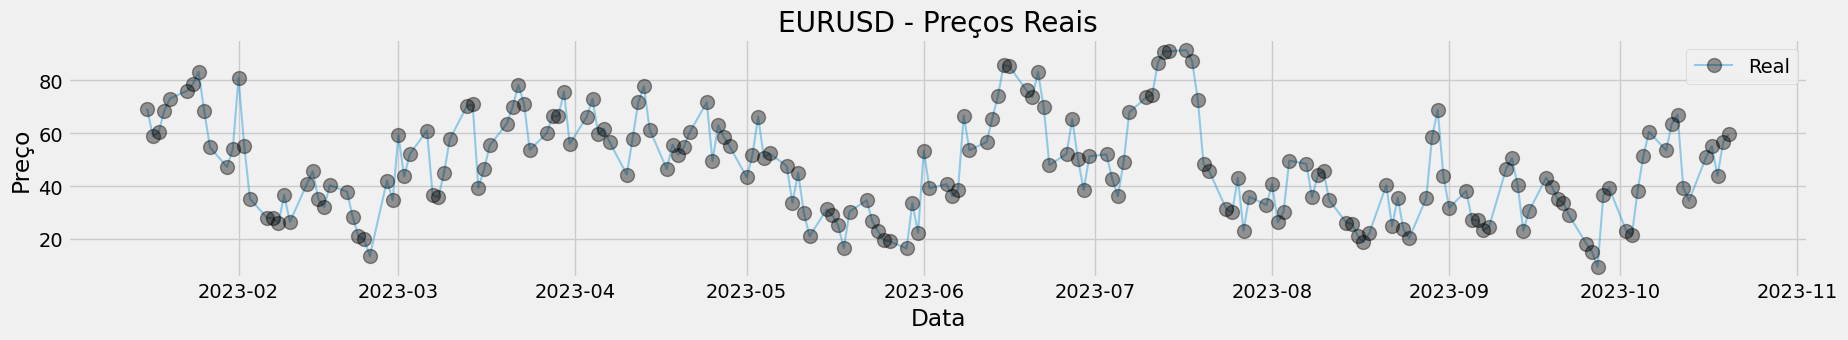

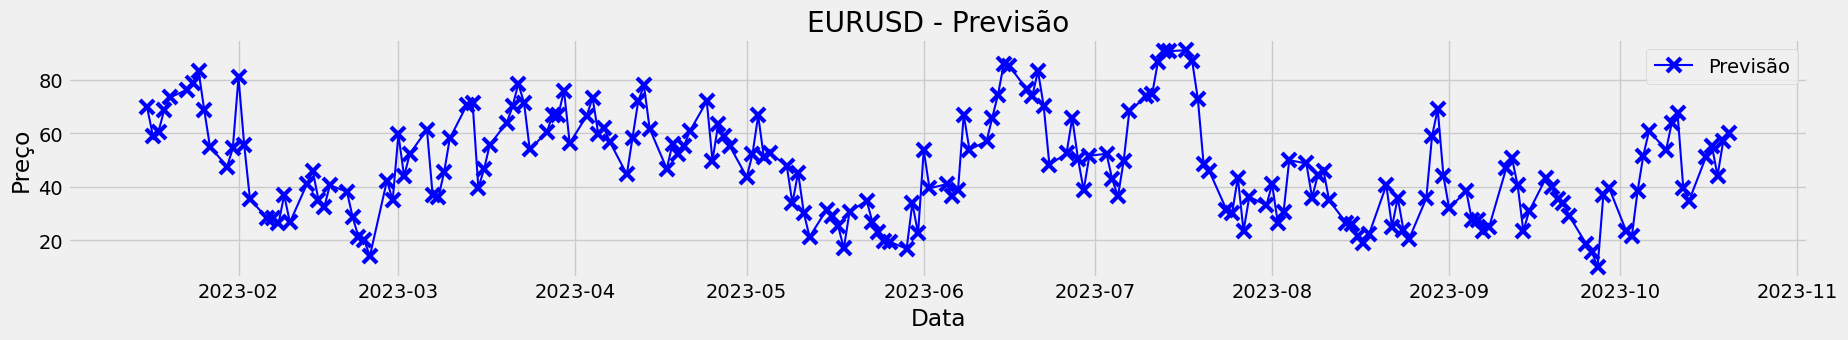

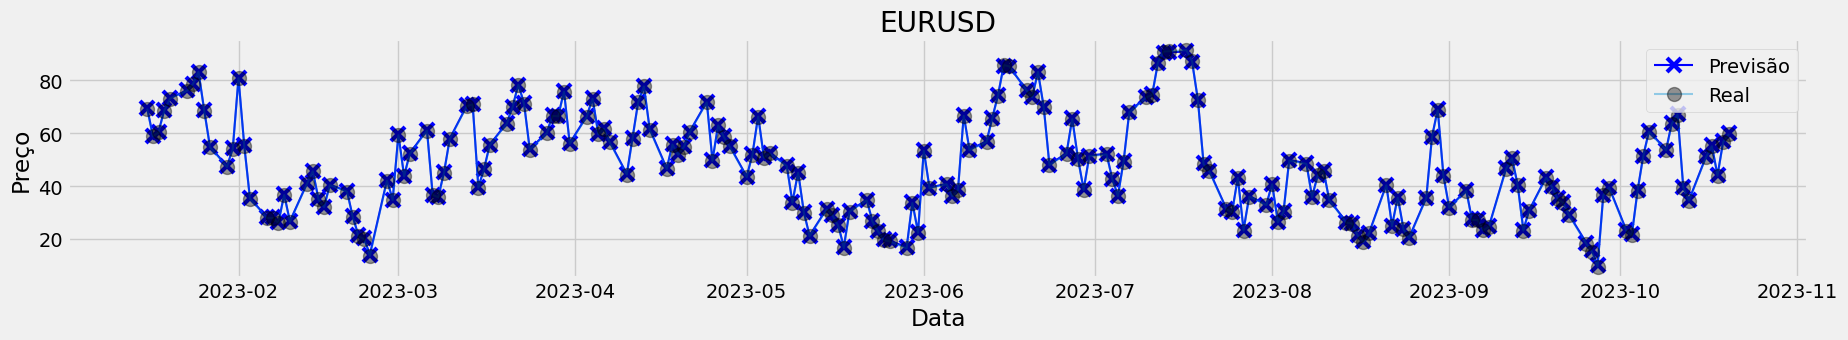

In [ ]:
# Plot the predictions and actual values
import matplotlib.pyplot as plt

# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.style.use('fivethirtyeight')
plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Real', linewidth=1.5, alpha=0.4, marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
plt.title(f"EURUSD - Preços Reais")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(3,1,2)
plt.style.use('fivethirtyeight')
plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Previsão', linewidth=1.5, marker='x', markersize=10, markeredgewidth=3, color='blue')
plt.title(f"EURUSD - Previsão")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()


plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.style.use('fivethirtyeight')
#plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Actual', linewidth = 3, alpha = 0.4)
#plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Predicted', linewidth = 1.5)
plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Previsão', linewidth=1.5, marker='x', markersize=10, markeredgewidth=3, color='blue')
plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Real', linewidth=1.5, alpha=0.4, marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
plt.title(f"EURUSD")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

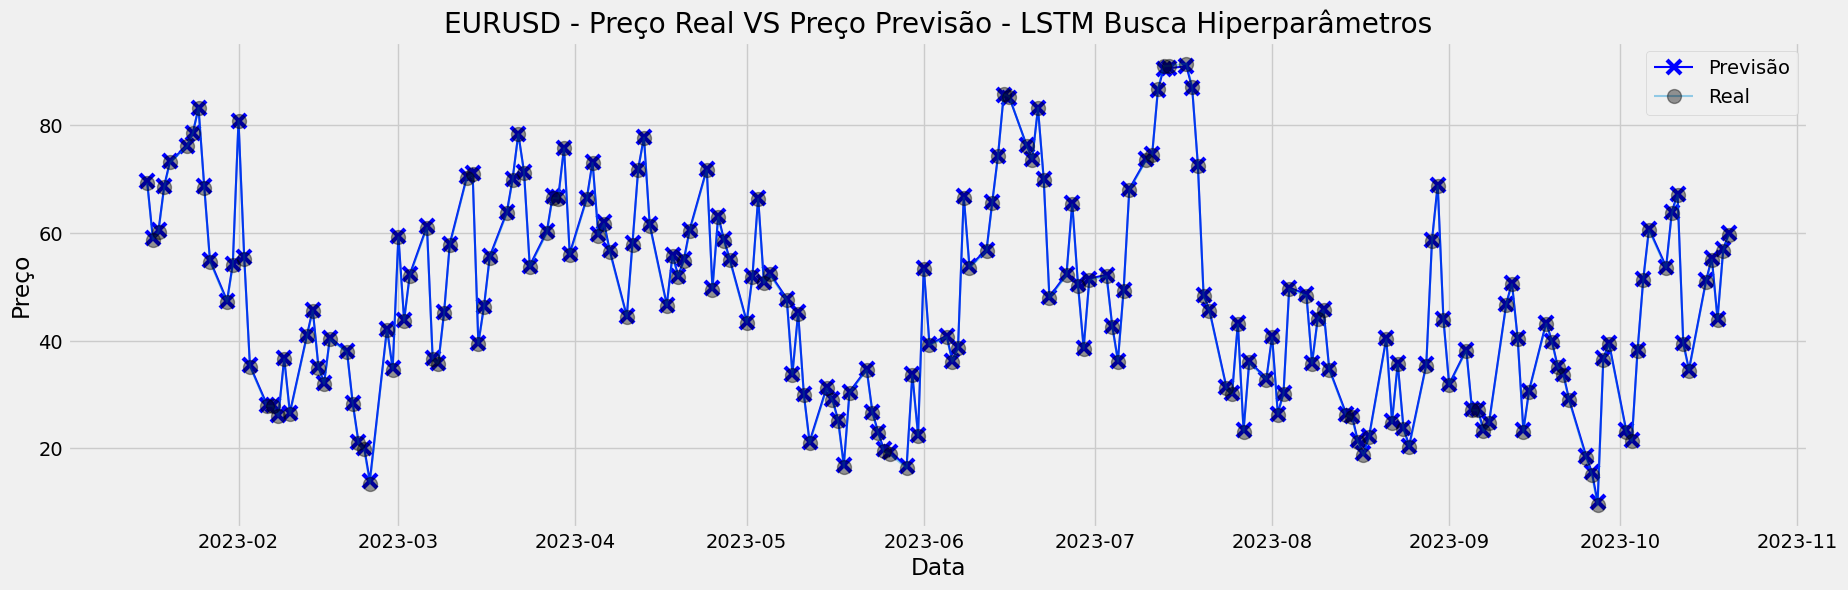

In [ ]:
plt.figure(figsize=(20, 6))
plt.style.use('fivethirtyeight')
#plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Actual', linewidth = 3, alpha = 0.4)
#plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Predicted', linewidth = 1.5)
plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Previsão', linewidth=1.5, marker='x', markersize=10, markeredgewidth=3, color='blue')
plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Real', linewidth=1.5, alpha=0.4, marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
plt.title(f"EURUSD - Preço Real VS Preço Previsão - LSTM Busca Hiperparâmetros")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.savefig('EURUSD - Preço Real VS Preço Previsão - LSTM Busca Hiperparâmetros.png', format='png')

plt.show()

In [ ]:
test_data.shape

(200, 1)

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/


#Linear Model RSI

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

#RNN usando RSI

###RNN básico RSI

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(rsi['rsi'].values.reshape(-1, 1))

In [ ]:
# Define the training and testing data
train_size = int(len(df_scaled) * 0.9)
train_data = df_scaled[:train_size, :]
test_data = df_scaled[train_size:, :]

In [ ]:
# Define the function to create a sliding window dataset
def create_dataset(dataset, time_steps=1):
    X_data, y_data = [], []
    for i in range(len(dataset)-time_steps-1):
        X_data.append(dataset[i:(i+time_steps), 0])
        y_data.append(dataset[i + time_steps, 0])
    return np.array(X_data), np.array(y_data)

In [ ]:
# Define the time steps and create the sliding window dataset
time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [ ]:
# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Definindo o modelo feedforward
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
25/25 [==============================] - 2s 10ms/step - loss: 0.0803 - val_loss: 0.0404
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0306
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0281 - val_loss: 0.0268
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.0294
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0242
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0214 - val_loss: 0.0239
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.0220
Epoch 8/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0195 - val_loss: 0.0245
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0185 - val_loss: 0.0215
Epoch 10/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0173 - val_loss: 0.0210
Epoch 11/50
25/25 

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

11/11 [==============================] - 0s 2ms/step


In [ ]:
# Inverse transform the predicted and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = y_test.reshape(y_pred.shape[0], 1)
y_test = scaler.inverse_transform(y_test)

In [ ]:
# Evaluate the model
#mse = mean_squared_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: ', mse)
print('MAE: ', mae)
print('MSLE: ', msle)
print('R-squared: ', r2)

MSE:  182.81520052324265
MAE:  11.001345742463934
MSLE:  0.12240316390202476
R-squared:  0.5087582170322028


MSE:  134.77140749813407
MSLE:  0.07904253527368346
MAE:  9.96601609933436
R-squared:  0.6314116214948139

In [ ]:
from datetime import datetime
dias = np.array(rsi.index.values)
dias = np.array(rsi.index.values, dtype='datetime64[D]')
datas_formatadas = [str(data) for data in dias]
datas = [x for x in datas_formatadas]
datas = np.array(datas)

(2000,)

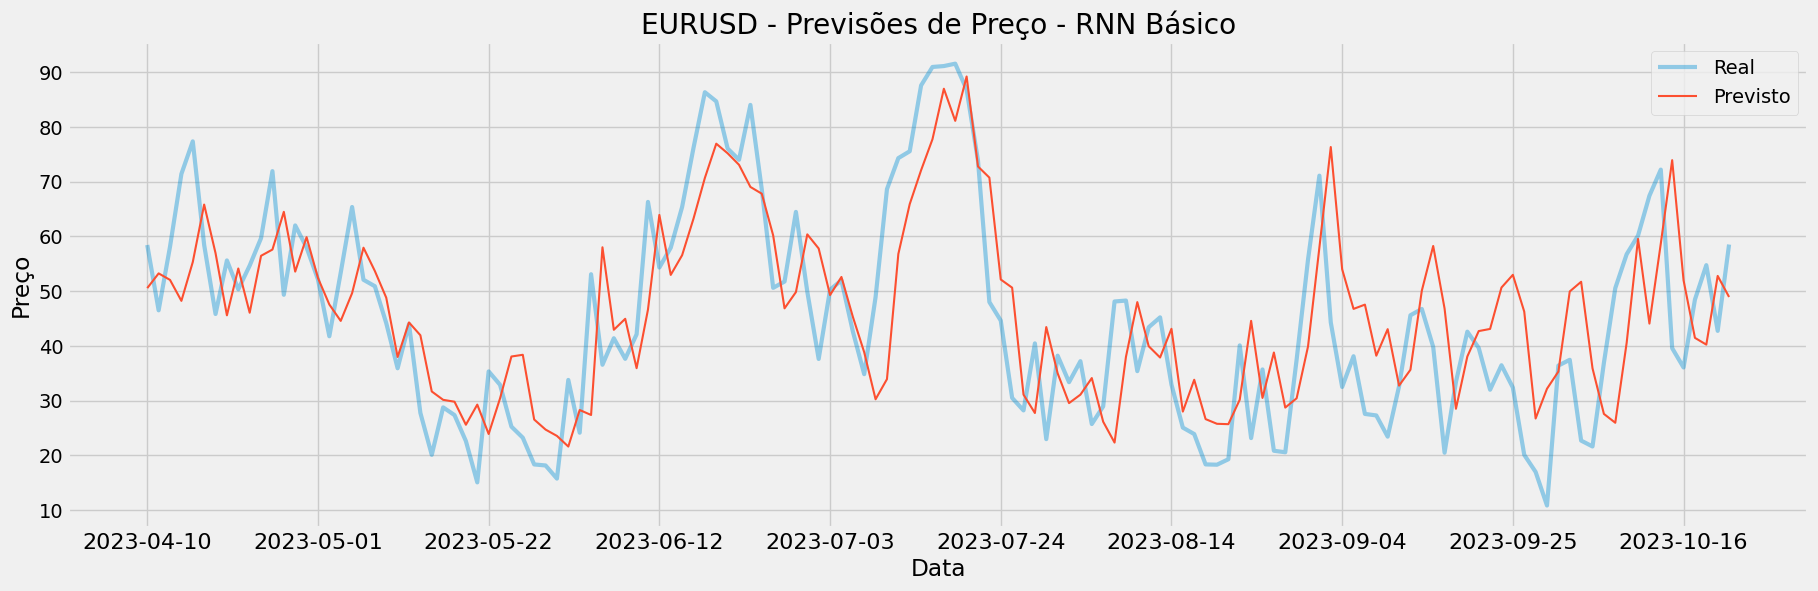

In [ ]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 6))
plt.style.use('fivethirtyeight')
plt.plot(datas[-140:], y_test[-140:], label='Real', linewidth = 3, alpha = 0.4)
plt.plot(datas[-140:], y_pred[-140:], label='Previsto', linewidth = 1.5)
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('EURUSD - Previsões de Preço - RNN Básico')
plt.legend()

#plt.xticks(rotation=0)
#plt.xticks(fontsize=10)
plt.xticks(ticks=datas[-140::15], fontsize=16)

plt.savefig('EURUSD - Previsões de Preço - RNN Básico.png', format='png')
plt.show()

###RNN aplicado no RSI - hyperparameters

In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(rsi['rsi'].values.reshape(-1, 1))

In [ ]:
# Define the training and testing data
train_size = int(len(df_scaled) * 0.9)
train_data = df_scaled[:train_size, :]
test_data = df_scaled[train_size:, :]

In [ ]:
# Define the function to create a sliding window dataset
def create_dataset(dataset, time_steps=1):
    X_data, y_data = [], []
    for i in range(len(dataset)-time_steps-1):
        X_data.append(dataset[i:(i+time_steps), 0])
        y_data.append(dataset[i + time_steps, 0])
    return np.array(X_data), np.array(y_data)

In [ ]:
# Define the time steps and create the sliding window dataset
time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [ ]:
# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define a função para criar o modelo linear com várias camadas (embora não seja eficaz)
def create_linear_model(neurons=50, layers=2, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units=neurons, activation='relu', input_shape=(train_data.shape[1],)))
    for i in range(layers):
        model.add(Dense(units=neurons, activation='relu'))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'neurons': [64, 128, 256],
    'layers': [2, 3, 4],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.01]
}

In [ ]:
# Define the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Create the KerasRegressor for hyperparameter tuning
model = KerasRegressor(build_fn=create_linear_model, epochs=50, batch_size=32, verbose=0)

# Perform the hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid.fit(train_data, train_data)

# Print the best parameters and score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", np.sqrt(-grid_result.best_score_))

Best parameters:  {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 128}
Best score:  0.00015513905215240866


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000000 using {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 128}
-0.000000 (0.000000) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 64}
-0.000000 (0.000000) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 128}
-0.000000 (0.000000) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.001, 'neurons': 256}
-0.000002 (0.000001) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.01, 'neurons': 64}
-0.000015 (0.000021) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.01, 'neurons': 128}
-0.000003 (0.000003) with: {'dropout': 0.2, 'layers': 2, 'learning_rate': 0.01, 'neurons': 256}
-0.000000 (0.000000) with: {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 64}
-0.000000 (0.000000) with: {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 128}
-0.000001 (0.000001) with: {'dropout': 0.2, 'layers': 3, 'learning_rate': 0.001, 'neurons': 256}
-0.000037 (0.000051) with: {'dropout': 0.

In [ ]:
# Get best parameters to build de A.I. model
best_model = grid_result.best_estimator_.model

In [ ]:
# Use the best model to make predictions on the test data
predictions = best_model.predict(test_data.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 0s 2ms/step


In [ ]:
import joblib  # ou import pickle

scaler_filename = 'scaler_rsi_rnn_hiperparametros.pkl'  # Escolha um nome de arquivo
joblib.dump(scaler, scaler_filename)  # Ou use pickle.dump(scaler, open(scaler_filename, 'wb'))

# Especifique o nome completo do arquivo para o modelo
model_filename = 'bestModel_rsi_rnn_hiperparametros.h5'

# Salve o melhor modelo
best_model.save(model_filename)

In [ ]:
# Evaluate the model
#mse = mean_squared_error(y_test, y_pred)
# msle = mean_squared_log_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(rsi['rsi'][train_size:], predictions)
mae = mean_absolute_error(rsi['rsi'][train_size:], predictions)
r2 = r2_score(rsi['rsi'][train_size:], predictions)

print('MSE: ', mse)
print('MAE: ', mae)
#print('MSLE: ', msle)
print('R-squared: ', r2)

MSE:  0.00023889646314122884
MAE:  0.014764647945054108
R-squared:  0.9999993277814597


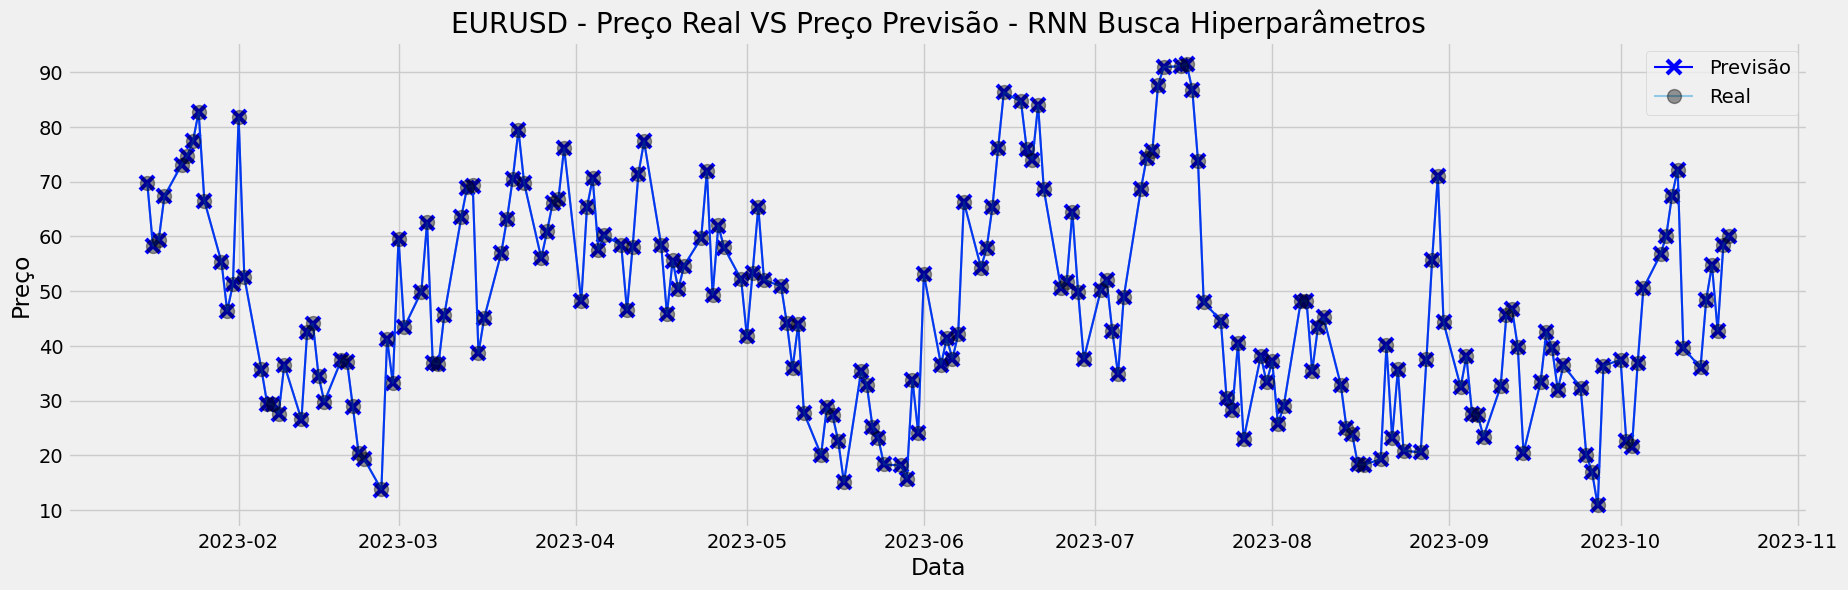

In [ ]:
plt.figure(figsize=(20, 6))
plt.style.use('fivethirtyeight')
#plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Actual', linewidth = 3, alpha = 0.4)
#plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Predicted', linewidth = 1.5)
plt.plot(pd.to_datetime(rsi.index[train_size:]), predictions, label='Previsão', linewidth=1.5, marker='x', markersize=10, markeredgewidth=3, color='blue')
plt.plot(pd.to_datetime(rsi.index[train_size:]), rsi['rsi'][train_size:], label='Real', linewidth=1.5, alpha=0.4, marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
plt.title(f"EURUSD - Preço Real VS Preço Previsão - RNN Busca Hiperparâmetros")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.savefig('EURUSD - Preço Real VS Preço Previsão - RNN Busca Hiperparâmetros.png', format='png')

plt.show()